In [1]:
import pandas as pd

In [2]:
resp = pd.read_csv('tickers_all.1yr.csv')
cutoff = '2024-01-01'
insider = pd.read_csv('insiders_by_declared_date.biweekly.csv')
congress = pd.read_csv('congress_by_declared_date.biweekly.csv')
resp.shape, insider.shape, congress.shape

((221593, 6), (17404, 7), (1501, 7))

In [3]:
ticker_union = list(set(insider['ticker'].tolist()) | set(congress['ticker'].tolist()))
resp = resp[resp['ticker'].isin(ticker_union)]
resp.shape

(185871, 6)

In [4]:
resp = resp[resp['open_price'] < 1]
resp.shape

(13361, 6)

In [5]:
congress['Republican Senate'] = congress['n_trades'] * (1 - congress['Democrat']) * congress['Senate']
congress['Republican House'] = congress['n_trades'] * (1 - congress['Democrat']) * (1 - congress['Senate'])
congress['Democrat Senate'] = congress['n_trades'] * (1 - congress['Democrat']) * congress['Senate']
congress['Democrat House'] = congress['n_trades'] * (1 - congress['Democrat'])* (1 - congress['Senate'])
congress['House'] = congress['Republican House'] + congress['Democrat House']
congress['House'] = congress['Republican Senate'] + congress['Democrat Senate']
congress['Republican'] = congress['Republican House'] + congress['Republican Senate']
congress['Democrat'] = congress['Democrat House'] + congress['Democrat Senate']
congress = congress.drop(columns=['Democrat','Senate'])
congress.shape

(1501, 11)

In [6]:
lista = []
for i in insider['Title'].unique():
    l = i.split(';')
    lista.extend(l)
for i in set(lista):
    l = []
    for x in insider['Title'].tolist():
        if i in x:
            l.append(1)
        else:
            l.append(0)
    insider[i] = l
insider = insider.drop('Title', axis=1)
insider.shape

(17404, 32)

In [7]:
dicta = {}
for i in congress.columns:
    if i in ['start_date','ticker']:
        continue
    dicta[i] = f'{i}_congress'
congress = congress.rename(dicta, axis=1)
congress.shape

(1501, 11)

In [8]:
combined = pd.merge(insider, congress, on=['start_date','ticker'], how='outer').fillna(0)
lista = []
for _, row in combined.iterrows():
    if row['end_date'] != 0:
        lista.append(row['end_date'])
    else:
        lista.append(row['end_date_congress'])
combined['end_date'] = lista
combined = combined.drop(columns=['end_date_congress'])
combined.shape

(18862, 40)

In [9]:
from datetime import datetime
combined['start_date'] = [datetime.strptime(i, '%Y-%m-%d') for i in combined['start_date'].tolist()]
combined = combined.sort_values('start_date')
combined.shape

(18862, 40)

In [10]:
resp = resp.dropna(subset=['price_change'])
resp = resp[['start_date','ticker','price_change']]
resp['start_date'] = [datetime.strptime(i, '%Y-%m-%d') for i in resp['start_date'].tolist()]
combined = pd.merge(combined, resp, on=['start_date','ticker'])
combined.shape

(812, 41)

In [11]:
cutoff = datetime.strptime(cutoff, '%Y-%m-%d')
train = combined[combined['start_date'] <= cutoff]
test = combined[combined['start_date'] > cutoff]
train.shape, test.shape

((469, 41), (343, 41))

In [12]:
X_train = train.drop(columns=['start_date','end_date','ticker', 'price_change'])
y_train = train['price_change'].tolist()
X_test = test.drop(columns=['start_date','end_date','ticker', 'price_change'])
y_test = test['price_change'].tolist()
X_train.shape, X_test.shape

((469, 37), (343, 37))

In [13]:
y_train = [1 if i >= 10 else 0 for i in y_train]
y_test = [1 if i >= 10 else 0 for i in y_test]


In [14]:
import sklearn
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline 
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, KFold
import numpy as np

In [15]:
from tqdm import tqdm

In [16]:
def tune_decision_tree_ccp_alpha(
    X,
    y,
    cv_folds=5,
    scoring="average_precision",
    random_state=42
):
    """
    Fits a DecisionTreeRegressor and tunes ccp_alpha using K-fold CV.

    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)
    y : array-like, shape (n_samples,)
    cv_folds : int
        Number of CV folds (default 10).
    scoring : str
        Scikit-learn scoring metric (default 'neg_mean_squared_error').
    random_state : int
        Random state for reproducibility.

    Returns
    -------
    best_tree : DecisionTreeRegressor
        Tree refit on the full data with the best ccp_alpha.
    results : dict
        Dictionary with:
        - 'ccp_alphas' : np.array of alphas tried
        - 'mean_scores': np.array of mean CV scores
        - 'std_scores' : np.array of std of CV scores
        - 'best_alpha' : best ccp_alpha value
    """

    # 1. Get pruning path (candidate alphas)
    base_tree = DecisionTreeClassifier(random_state=random_state)
    path = base_tree.cost_complexity_pruning_path(X, y)
    ccp_alphas = path.ccp_alphas

    # Often we drop the last alpha (it prunes the tree to a single node)
    ccp_alphas = ccp_alphas[:-1]

    mean_scores = []
    std_scores = []

    kf = KFold(n_splits=cv_folds, shuffle=True, random_state=random_state)

    # 2. Cross-validate over all candidate alphas
    for alpha in tqdm(ccp_alphas):
        tree = DecisionTreeClassifier(random_state=random_state, ccp_alpha=alpha)
        scores = cross_val_score(tree, X, y, cv=kf, scoring=scoring)
        mean_scores.append(scores.mean())
        std_scores.append(scores.std())

    mean_scores = np.array(mean_scores)
    std_scores = np.array(std_scores)

    # 3. Pick best alpha (for 'neg_*' scores, higher is better)
    best_idx = np.argmax(mean_scores)
    best_alpha = ccp_alphas[best_idx]

    # 4. Refit on full data with best alpha
    best_tree = DecisionTreeClassifier(random_state=random_state, ccp_alpha=best_alpha)
    best_tree.fit(X, y)

    results = {
        "ccp_alphas": ccp_alphas,
        "mean_scores": mean_scores,
        "std_scores": std_scores,
        "best_alpha": best_alpha,
    }

    return best_tree, results

In [17]:
best_tree,results = tune_decision_tree_ccp_alpha(X_train, y_train)

100%|███████████████████████████████████████████| 25/25 [00:00<00:00, 28.19it/s]


In [18]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,      # TPR
    confusion_matrix,
    f1_score,
    roc_auc_score,
    average_precision_score
)
import numpy as np

def evaluate_tree(model, X_train, y_train, X_test, y_test, average='binary'):
    """
    Evaluate a classifier with multiple metrics.

    average='binary' for binary classification.
    Use 'macro' or 'weighted' for multiclass precision/recall/F1.
    """
    y_pred = model.predict(X_test)

    # confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Binary case: extract TN, FP, FN, TP and compute FPR/TPR
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        fpr = fp / (fp + tn) if (fp + tn) > 0 else np.nan
        tpr = tp / (tp + fn) if (tp + fn) > 0 else np.nan
    else:
        tn = fp = fn = tp = np.nan
        tpr = recall_score(y_test, y_pred, average=average)
        fpr = np.nan  # not well-defined as a single scalar in multiclass

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average=average)
    f1 = f1_score(y_test, y_pred, average=average)

    # --- ROC AUC & PR AUC (need scores/probabilities) ---
    roc_auc = np.nan
    pr_auc = np.nan
    try:
        if hasattr(model, "predict_proba"):
            proba = model.predict_proba(X_test)
            # binary case
            if proba.shape[1] == 2:
                y_score = proba[:, 1]
                roc_auc = roc_auc_score(y_test, y_score)
                pr_auc = average_precision_score(y_test, y_score)
            else:
                # multiclass ROC AUC (one-vs-rest)
                roc_auc = roc_auc_score(y_test, proba, multi_class="ovr")
                # PR AUC for multiclass is more nuanced; left as NaN here
        elif hasattr(model, "decision_function"):
            scores = model.decision_function(X_test)
            roc_auc = roc_auc_score(y_test, scores)
            pr_auc = average_precision_score(y_test, scores)
    except ValueError:
        # e.g. only one class present in y_test, metrics undefined
        roc_auc = np.nan
        pr_auc = np.nan

    return {
        "accuracy": acc,
        "precision": prec,
        "tpr": tpr,
        "fpr": fpr,
        "f1": f1,
        "roc_auc": roc_auc,
        "pr_auc": pr_auc,
        "tn": tn,
        "fp": fp,
        "fn": fn,
        "tp": tp,
        "confusion_matrix": cm
    }


In [19]:
eval_results = evaluate_tree(best_tree, X_train, y_train, X_test, y_test)

print("\n=== Performance ===")
for k, v in eval_results.items():
    if k == "confusion_matrix":
        print(f"{k}:\n{v}")
    else:
        print(f"{k}: {v:.4f}")



=== Performance ===
accuracy: 0.8251
precision: 0.8408
tpr: 0.9756
fpr: 0.9464
f1: 0.9032
roc_auc: 0.6889
pr_auc: 0.9023
tn: 3.0000
fp: 53.0000
fn: 7.0000
tp: 280.0000
confusion_matrix:
[[  3  53]
 [  7 280]]


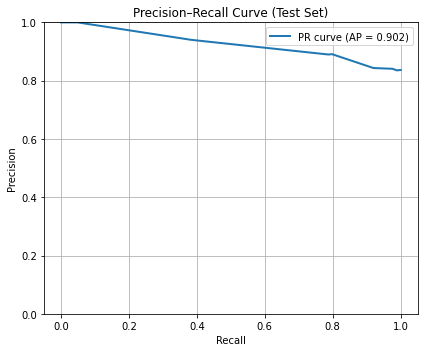

In [20]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Get scores for the positive class on the test set
y_score = best_tree.predict_proba(X_test)[:, 1]

# Compute precision-recall pairs
precision, recall, thresholds = precision_recall_curve(y_test, y_score)

# PR AUC (average precision)
pr_auc = average_precision_score(y_test, y_score)

# Plot
plt.figure(figsize=(6, 5))
plt.ylim([0,1])
plt.plot(recall, precision, linewidth=2, label=f'PR curve (AP = {pr_auc:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve (Test Set)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [25]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,      # TPR
    confusion_matrix,
    f1_score,
    roc_auc_score,
    average_precision_score,
    roc_curve
)
import numpy as np

def evaluate_tree(model, X_train, y_train, X_test, y_test, average='binary'):
    """
    Evaluate a classifier with multiple metrics.

    - Uses test-set scores to pick an optimal threshold (Youden's J)
    - Applies that threshold to compute y_pred, confusion matrix, and metrics.

    average='binary' for binary classification.
    Use 'macro' or 'weighted' for multiclass precision/recall/F1.
    """
    # --- Get scores for positive class ---
    y_score = None

    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X_test)
        # assume binary if 2 columns
        if proba.shape[1] == 2:
            y_score = proba[:, 1]
        else:
            # multiclass: can't do a single threshold in same way
            y_pred = model.predict(X_test)
    elif hasattr(model, "decision_function"):
        scores = model.decision_function(X_test)
        if scores.ndim == 1:
            y_score = scores
        elif scores.ndim == 2 and scores.shape[1] == 2:
            y_score = scores[:, 1]
        else:
            y_pred = model.predict(X_test)
    else:
        # no score-based method: just hard predictions
        y_pred = model.predict(X_test)

    # --- If we have scores, find best threshold and derive y_pred from it ---
    best_threshold = None
    if y_score is not None:
        fpr_curve, tpr_curve, thresholds = roc_curve(y_test, y_score)
        youden_j = tpr_curve - fpr_curve
        idx_best = np.argmax(youden_j)
        best_threshold = thresholds[idx_best]

        # Apply optimal threshold to get final predictions
        y_pred = (y_score >= best_threshold).astype(int)

    # --- Confusion matrix and metrics based on y_pred ---
    cm = confusion_matrix(y_test, y_pred)

    # Binary case: extract TN, FP, FN, TP and compute FPR/TPR
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        fpr = fp / (fp + tn) if (fp + tn) > 0 else np.nan
        tpr = tp / (tp + fn) if (tp + fn) > 0 else np.nan
    else:
        tn = fp = fn = tp = np.nan
        tpr = recall_score(y_test, y_pred, average=average)
        fpr = np.nan  # not well-defined as a single scalar in multiclass

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average=average)
    f1 = f1_score(y_test, y_pred, average=average)

    # --- ROC AUC & PR AUC (still use scores, not thresholded preds) ---
    roc_auc = np.nan
    pr_auc = np.nan
    try:
        if y_score is not None:
            roc_auc = roc_auc_score(y_test, y_score)
            pr_auc = average_precision_score(y_test, y_score)
    except ValueError:
        # e.g. only one class present in y_test
        roc_auc = np.nan
        pr_auc = np.nan

    return {
        "accuracy": acc,
        "precision": prec,
        "tpr": tpr,
        "fpr": fpr,
        "f1": f1,
        "roc_auc": roc_auc,
        "pr_auc": pr_auc,
        "best_threshold": best_threshold,
        "tn": tn,
        "fp": fp,
        "fn": fn,
        "tp": tp,
        "confusion_matrix": cm
    }


In [26]:
dist = np.sqrt((1 - tpr)**2 + (fpr)**2)
idx_tl = np.argmin(dist)
best_thresh_tl = thresholds[idx_tl]

print("Best threshold by top-left distance:", best_thresh_tl)
print("TPR:", tpr[idx_tl], "FPR:", fpr[idx_tl])


Best threshold by top-left distance: 0.875
TPR: 0.7979094076655052 FPR: 0.5


In [30]:
evaluate_tree(best_tree, X_train, y_train, X_test, y_test, average='binary')

{'accuracy': 0.749271137026239,
 'precision': 0.8910505836575876,
 'tpr': 0.7979094076655052,
 'fpr': 0.5,
 'f1': 0.8419117647058824,
 'roc_auc': 0.6889310602289695,
 'pr_auc': 0.9023266941164361,
 'best_threshold': 0.875,
 'tn': 28,
 'fp': 28,
 'fn': 58,
 'tp': 229,
 'confusion_matrix': array([[ 28,  28],
        [ 58, 229]])}

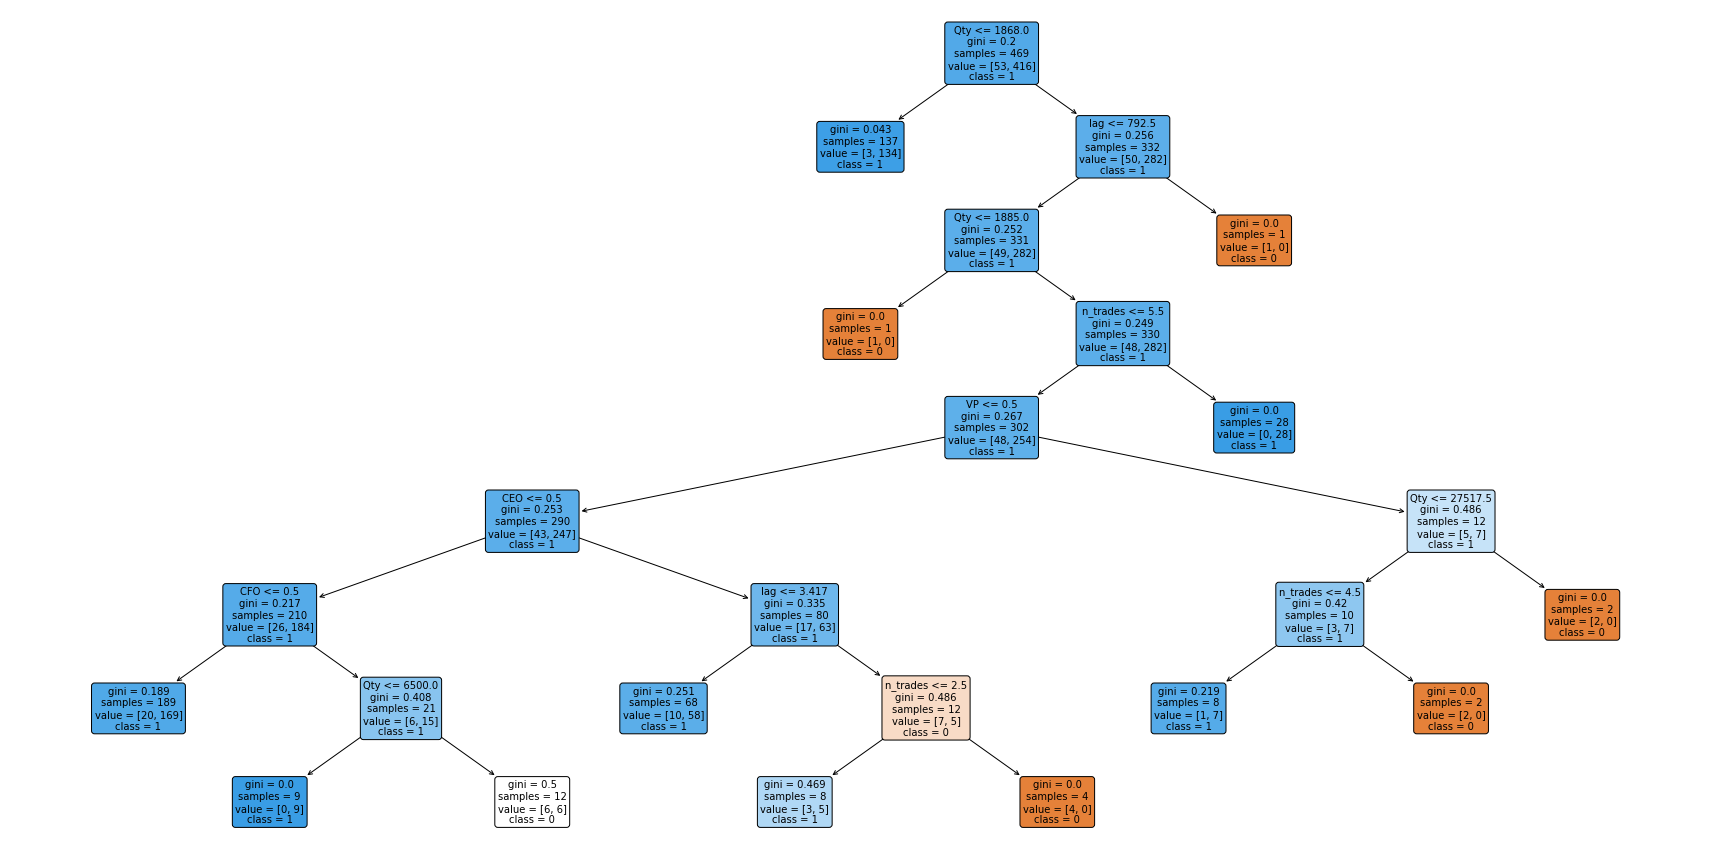

In [32]:
from sklearn import tree
import matplotlib.pyplot as plt

feature_names = getattr(X_train, "columns", None)  # works if X_train is a DataFrame
class_names = [str(c) for c in np.unique(y_train)]  # for classifier

plt.figure(figsize=(24, 12))
tree.plot_tree(
    best_tree,
    feature_names=feature_names,
    class_names=class_names,
    filled=True,
    rounded=True,
    fontsize=10
)
plt.tight_layout()
plt.show()
